# <center>Курсовой проект<center>

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import chi2_contingency, boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from collections import Counter

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

C:\Users\GruXsqK\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\GruXsqK\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def get_clear_data(df_in, months_median=None):

    DF = df_in.copy()
    
    YEARS_DICT = {'< 1 year': 1,
                  '1 year': 2,
                  '2 years': 3,
                  '3 years': 4,
                  '4 years': 5,
                  '5 years': 6,
                  '6 years': 7,
                  '7 years': 8,
                  '8 years': 9,
                  '9 years': 10,
                  '10+ years': 11}
    
    DF.loc[(DF['Credit Score'] > 999), 'Credit Score'] = DF.loc[(DF['Credit Score'] > 999), 'Credit Score']/10
    
#     if not credit_score_median:
#         credit_score_median = DF.loc[(DF['Credit Score'].notnull()), 'Credit Score'].median()
        
#     DF.loc[(DF['Credit Score'].isnull()), 'Credit Score'] = credit_score_median
    
    DF.loc[(DF['Current Loan Amount']==99999999), 'Current Loan Amount'] = \
        np.absolute(DF.loc[(DF['Current Loan Amount']==99999999), 'Maximum Open Credit'] - \
        DF.loc[(DF['Current Loan Amount']==99999999), 'Current Credit Balance'])
    
    DF.loc[(DF['Bankruptcies'].isnull()), 'Bankruptcies'] = 0
    
    if not months_median:
        months_median = round(DF.loc[DF['Months since last delinquent'].notnull(), 'Months since last delinquent'].median())
    
    DF.loc[(DF['Months since last delinquent'].isnull()) & \
           (DF['Number of Credit Problems']!=0), 'Months since last delinquent'] = months_median
    DF.loc[(DF['Months since last delinquent'].isnull()) & \
           (DF['Number of Credit Problems']==0), 'Months since last delinquent'] = 0
    
    DF.loc[DF['Maximum Open Credit']==0, 'Maximum Open Credit'] = DF.loc[DF['Maximum Open Credit']==0, 'Current Loan Amount']
    
    MAIN_PURPOSE = ['debt consolidation', 'home improvements', 'business', 'other']
    SECONDARY_PURPOSE = np.setdiff1d(DF['Purpose'].unique(), MAIN_PURPOSE)
    DF.replace(['business loan', 'small business'], 'business', inplace=True)
    DF.replace('buy house', 'home improvements', inplace=True)
    DF.replace(SECONDARY_PURPOSE, 'other', inplace=True)

    DF.replace(YEARS_DICT, inplace=True)
    DF['Years in current job'].fillna(0, inplace = True)
    
    return DF, months_median

In [3]:
def plot_r2_forest(X_train, y_train, X_valid, y_valid, name_param, param_data):
    
    r2_on_valid = []
    r2_on_train = []

    for itm in param_data:
        
        if name_param == 'n_estimators':
            clf = RFR(n_estimators=itm, random_state=42, n_jobs=-1)
        elif name_param == 'max_features':
            clf = RFR(max_features=itm, random_state=42, n_jobs=-1)
        elif name_param == 'max_depth':
            clf = RFR(max_depth=itm, random_state=42, n_jobs=-1)
        elif name_param == 'min_samples_leaf':
            clf = RFR(min_samples_leaf=itm, random_state=42, n_jobs=-1)
        else:
            clf = RFR(random_state=itm, n_jobs=-1)
        
        clf.fit(X_train, y_train)

        r2_on_valid.append(r2_score(y_valid, clf.predict(X_valid)))
        r2_on_train.append(r2_score(y_train, clf.predict(X_train)))
        
    plt.figure(figsize = (8, 6))
    plt.plot(param_data, r2_on_valid, label="valid")
    plt.plot(param_data, r2_on_train, label="train")

    plt.xlabel(f"Значение параметра '{name_param}'")
    plt.ylabel('R2_score')

    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [9]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [10]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# Обзор датасета

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Обработка выбросов и пропусков

__Посмотрим на разброс значений каждого параметра.__

__Все изменения будут описываться по порядку, но будут добавлены в одну общую функцию.__

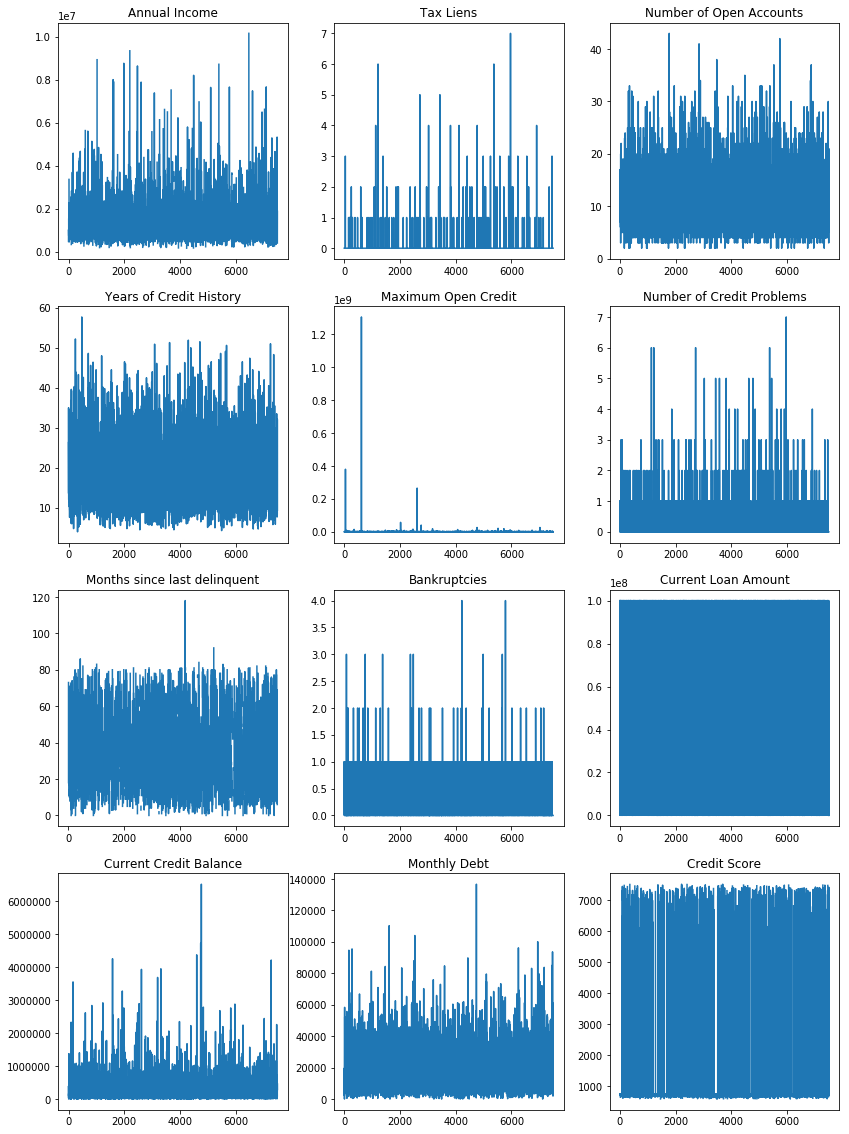

In [13]:
colmns = df_train.select_dtypes(exclude=['object', 'int64']).columns
fig, ax = plt.subplots(nrows=4, ncols=3)
fig.set_size_inches(14, 20, forward=True)

for ax_i, colmn in zip(ax.flatten(), colmns):
    ax_i.plot(df_train[colmn])
    ax_i.set_title(colmn)

__Во многих параметрах присутствуют выбросы, проанализируем каждый по отдельности.__

Количество выбросов Credit Score (> 999): 400 ( 5.33 %)


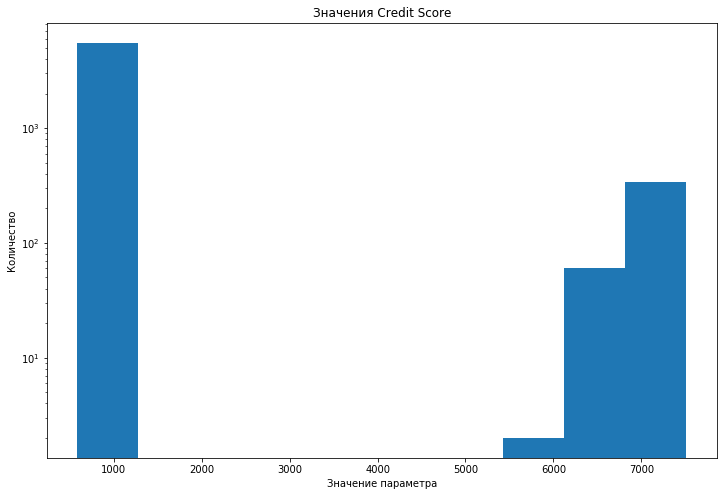

In [14]:
print('Количество выбросов Credit Score (> 999):', df_train.loc[df_train['Credit Score'] > 999].shape[0],
      '(', round(100*df_train.loc[df_train['Credit Score'] > 999].shape[0]/df_train['Credit Score'].shape[0], 2), '%)')

plt.figure(figsize = (12, 8))
plt.hist(df_train['Credit Score'], bins=10, log=True, label=['Credit Score'])
plt.title('Значения Credit Score')
plt.xlabel('Значение параметра')
plt.ylabel('Количество')
plt.show();

In [15]:
df_train['Credit Score'].loc[df_train['Credit Score'] > 999].head(8)

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
152    7140.0
153    7470.0
198    7370.0
Name: Credit Score, dtype: float64

__На графике видно, что значения кредитного рейтинга имеют выбросы, которые на порядок отличаются от других. Исходя из того, что данных выбросов менее 6%, выбросы кратны 10 и по данным банков России данный рейтинг принимает значения от 1 до 999; сократим выбросы на один порядок.__

Медианное значение Credit Score: 729.0


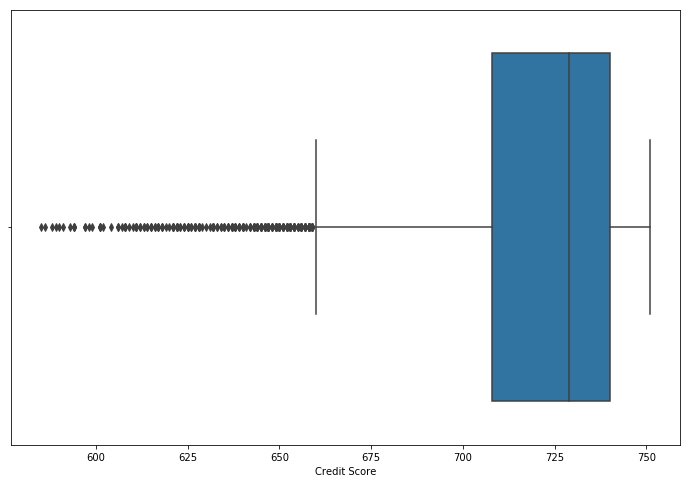

In [16]:
df_train.loc[(df_train['Credit Score'] > 999), 'Credit Score'] = \
    df_train.loc[(df_train['Credit Score'] > 999), 'Credit Score']/10
    
credit_score_data = df_train.loc[(df_train['Credit Score'].notnull()), 'Credit Score']
plt.figure(figsize = (12, 8))
sns.boxplot(credit_score_data)

print('Медианное значение Credit Score:', credit_score_data.median())

__Исходя из данного графика можно сделать вывод о смещении признака Credit Score. Т.к. частота не равномерна, то пропущенные значения кредитного рейтинга приравняем к его медиане.__

In [17]:
df_train.loc[(df_train['Current Loan Amount']==99999999)].head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0


__В датасете присутствуют наблюдения с выбросами "Current Loan Amount", которые равны 99999999. Приравняем их к модулю разности "Maximum Open Credit" и "Current Credit Balance". Таким образом мы допускаем, что текущий кредит является наибольшим и текущая сумма кредита равна разности максимального кредита и текущего баланса кредита.__

In [18]:
df_train[df_train['Bankruptcies'].isnull()].shape[0]

14

__Пустые записи о банкротствах заменим на 0.__

In [19]:
print(df_train[(df_train['Months since last delinquent']==0) & (df_train['Number of Credit Problems']!=0)].shape[0])
print(df_train[(df_train['Months since last delinquent'].isnull()) & (df_train['Number of Credit Problems']!=0)].shape[0])
print(df_train[(df_train['Months since last delinquent'].isnull())].shape[0])
print(df_train[(df_train['Number of Credit Problems']!=0)].shape[0])

0
524
4081
1031


__Пустые записи 'Months since last delinquent' заменим на 0, где 'Number of Credit Problems' равен 0, и на медиану 'Months since last delinquent', где 'Number of Credit Problems' >= 1.__

__Рассмотрим категориальные переменные.__

In [20]:
for cat_colname in df_train.select_dtypes(include=['object']).columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 50 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
**************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
**************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
************************

**Наблюдение**

__Изучив получившиеся данные, видно, что многие значения признака Purpose имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет объединить их в одну общую категорию.__

**Гипотеза** 

* __Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы__
* __Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы__
* __Критерий: Хи-квадрат Пирсона__
* __Уровень значимости $\normalsize \alpha$: 0.05__
* __Критическая область: двухсторонняя__

__Для проверки данной гипотезы необходимо подать наблюдаемые частоты значений признака Purpose в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.__

__*Проверим нашу гипотезу используя критерий Хи-квадрат Пирсона*__

In [21]:
all_purpose = df_train['Purpose'].unique()
main_purpose = ['debt consolidation', 'home improvements', 'business loan']
secondary_purpose = np.setdiff1d(all_purpose, main_purpose)

df = df_train.copy()
purpose_and_targets = df.loc[df['Purpose'].isin(secondary_purpose), ['ID', 'Purpose', 'Credit Default']]
purpose_and_targets['ID'] = df.index[:len(purpose_and_targets['ID'])]

table = purpose_and_targets.pivot_table(values='ID', index='Purpose', columns='Credit Default', aggfunc='count', fill_value=0)
chi2, p, dof, expected = chi2_contingency(table, correction=False)
print('p-value =', p)
table

p-value = 0.10475408532631993


Credit Default,0,1
Purpose,,
buy a car,72,24
buy house,25,9
educational expenses,9,1
major purchase,31,9
medical bills,49,22
moving,9,2
other,468,197
renewable energy,0,2
small business,12,14


__P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории: other, buy a car, medical bills, major purchase, take a trip, buy house, small business, wedding, moving, educational expenses, vacation и renewable energy одинаково влияют на целевую переменную и их можно объединить в одну категорию (other).__

In [22]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

__Заменим значения параметра 'Years in current job' на числовые, причем 'nan' заменим на 0, '10+ years' заменим на 11, а '< 1 year' на 1 (округление в большую сторону)__

__Применим все вышеуказанные изменения к датасетам__

In [23]:
df_train_clean, months_median = get_clear_data(df_train)
df_test_clean = get_clear_data(df_test, months_median)[0]

# Анализ данных

__Построим корреляционную матрицу признаков__

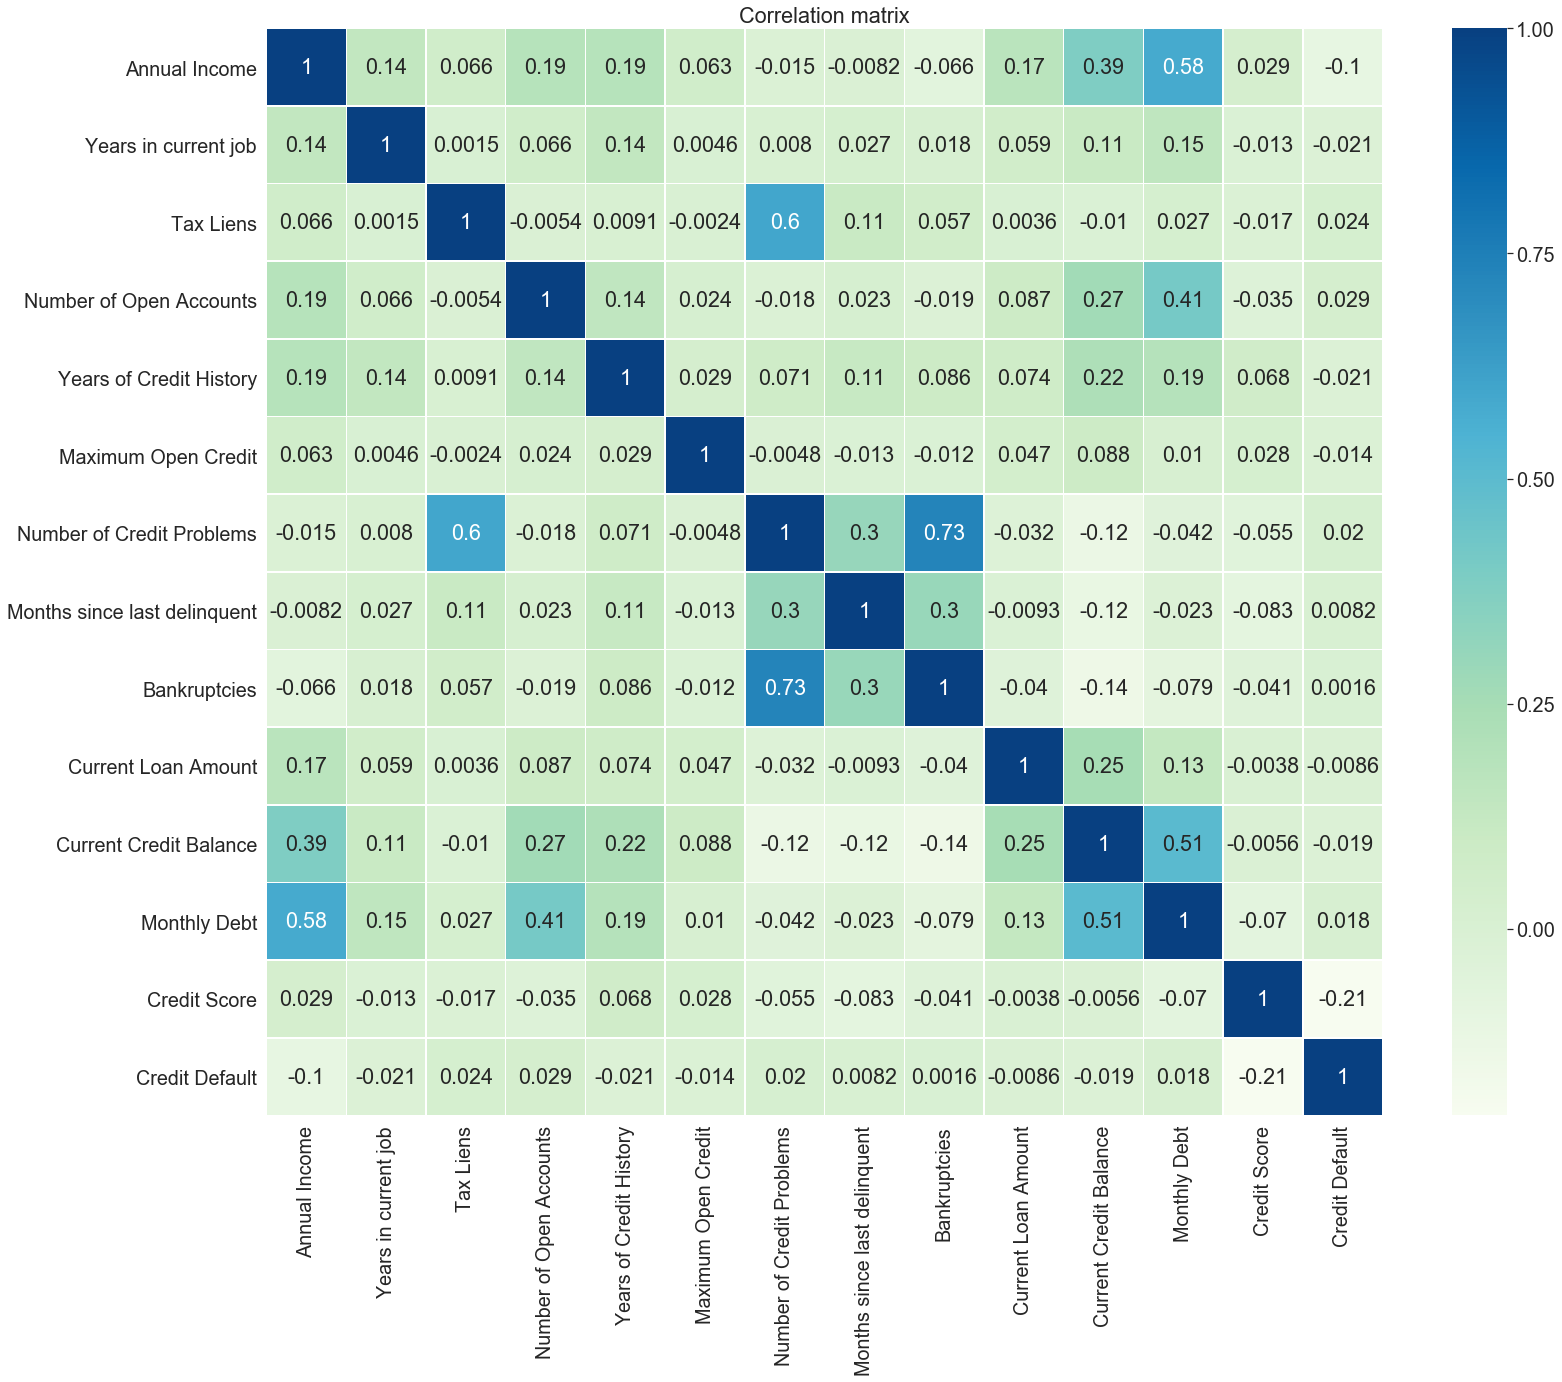

In [24]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.8)
sns.heatmap(df_train_clean.corr().round(4), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

__Т.к. большинство признаков не коорелируют с другими, то дополнительные преобразования данных не нужны. Так же видно, что 'Annual Income' и 'Credit Score' слабо коррелируют только с несколькими признаками, значит вычислить пропущенные значения можно с помощью линейной регрессии.__

__Преобразуем колонки 'Home Ownership', 'Purpose' и 'Term' в дамми-переменные.__

In [25]:
df_train_clean = pd.get_dummies(df_train_clean, columns=['Home Ownership', 'Purpose', 'Term'])
df_test_clean = pd.get_dummies(df_test_clean, columns=['Home Ownership', 'Purpose', 'Term'])

__Разобьем датасет на X и Y, выполним нормализацию признаков с помощью MinMaxScaler'а, целевую переменную приведем к нормальному закону распределению с помощью преобразования Бокса-Кокса, разобьем на тренировочный и тестовый наборы данным и обучим несколько моделей.__

In [26]:
X_score = df_train_clean[df_train_clean['Credit Score'].notnull()].drop(['Credit Score', 
                                                                         'Credit Default', 
                                                                         'Annual Income'], axis=1).copy()
Y_score = df_train_clean[df_train_clean['Credit Score'].notnull()]['Credit Score'].copy()

In [27]:
X_train_score, X_test_score, Y_train_score, Y_test_score = train_test_split(X_score, Y_score, test_size=0.25)

In [28]:
scaler_score = MinMaxScaler()
X_train_score = pd.DataFrame(scaler_score.fit_transform(X_train_score), columns=X_score.columns)
X_test_score = pd.DataFrame(scaler_score.transform(X_test_score), columns=X_score.columns)

In [29]:
lr_score = LinearRegression().fit(X_train_score, Y_train_score)
lasso_score = Lasso().fit(X_train_score, Y_train_score)
ridge_score = Ridge().fit(X_train_score, Y_train_score)
rfr_score = RFR(n_estimators=500, n_jobs=-1).fit(X_train_score, Y_train_score)

In [30]:
Y_pred_score_lr = lr_score.predict(X_test_score)
Y_pred_score_lasso = lasso_score.predict(X_test_score)
Y_pred_score_ridge = ridge_score.predict(X_test_score)
Y_pred_score_rfr = rfr_score.predict(X_test_score)

In [31]:
print('LinearRegression:', r2_score(Y_test_score, Y_pred_score_lr))
print('Lasso:', r2_score(Y_test_score, Y_pred_score_lasso))
print('Ridge:', r2_score(Y_test_score, Y_pred_score_ridge))
print('RandomForestRegressor:', r2_score(Y_test_score, Y_pred_score_rfr))

LinearRegression: 0.26068752250293403
Lasso: 0.20779057507415144
Ridge: 0.2614415308125859
RandomForestRegressor: 0.3153835817527023


In [32]:
for model in (lr_score, lasso_score, ridge_score):

    print(f"{model}\n\n{'w0':35}{model.intercept_}")

    for itm in zip(X_score.columns, model.coef_):
        print(f"{itm[0]:35}{itm[1]}")
          
    print('\n', '#'*60, '\n')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

w0                                 707.792043363535
Years in current job               0.05432030870389047
Tax Liens                          38.84584417076721
Number of Open Accounts            -1.6095949007723538
Years of Credit History            17.71384337611444
Maximum Open Credit                40.162286271878735
Number of Credit Problems          -40.16086902680086
Months since last delinquent       -11.740433765593588
Bankruptcies                       11.793665594576748
Current Loan Amount                39.32530612190932
Current Credit Balance             -1.8577957726941379
Monthly Debt                       -14.173578660832408
Home Ownership_Have Mortgage       -1.777484473646332
Home Ownership_Home Mortgage       3.1816990148356
Home Ownership_Own Home            -0.6309753051068177
Home Ownership_Rent                -0.7732392360822502
Purpose_business                   -6.383816316

__Самый лучший показатель коэффициента детерминации показывает RandomForestRegressor. Подберем ему лучшие гиперпараметры для снижения переобучения.__

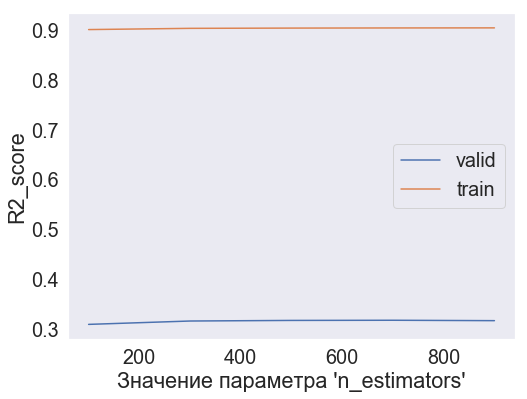

In [33]:
plot_r2_forest(X_train_score, Y_train_score, X_test_score, Y_test_score, 'n_estimators', np.arange(100, 901, 200))

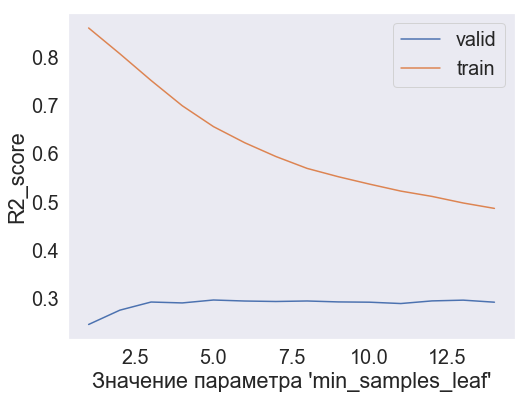

In [34]:
plot_r2_forest(X_train_score, Y_train_score, X_test_score, Y_test_score, 'min_samples_leaf', np.arange(1, 15))

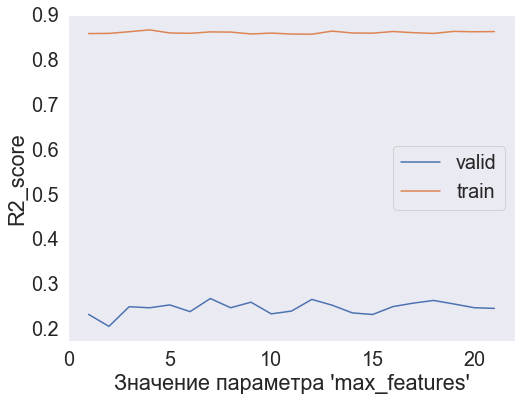

In [35]:
plot_r2_forest(X_train_score, Y_train_score, X_test_score, Y_test_score, 'max_features', np.arange(1, 22))

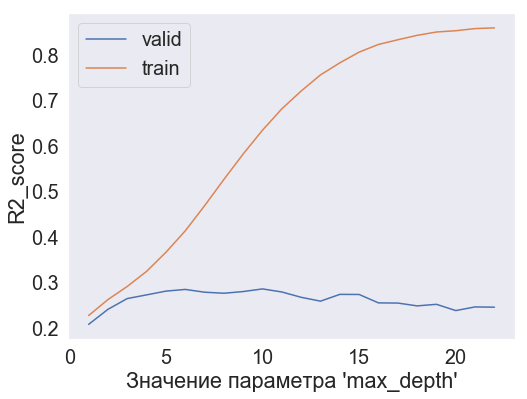

In [36]:
plot_r2_forest(X_train_score, Y_train_score, X_test_score, Y_test_score, 'max_depth', np.arange(1, 23))

In [37]:
papameters = [{'n_estimators': [500],
               'min_samples_leaf': np.arange(10, 13),
               'max_features': np.arange(10, 14),
               'max_depth': np.arange(5, 8)}]

clf = GridSearchCV(estimator=RFR(random_state=42, n_jobs=-1), param_grid=papameters, scoring='r2')
clf.fit(X_train_score, Y_train_score)

clf.best_params_

{'max_depth': 7,
 'max_features': 10,
 'min_samples_leaf': 10,
 'n_estimators': 500}

In [38]:
rfr_score_best = RFR(n_estimators=500,
                     max_features=13,
                     min_samples_leaf=10,
                     max_depth=7,
                     n_jobs=-1).fit(X_train_score, Y_train_score)

Y_pred_score_boxcox_best = rfr_score_best.predict(X_test_score)

print('RandomForestRegressor_best:', r2_score(Y_test_score, Y_pred_score_boxcox_best))

RandomForestRegressor_best: 0.31032068824219505


__Обучим модель с лучшими параметрами на всем массиве данных__

In [39]:
X_score_empty = df_train_clean[df_train_clean['Credit Score'].isnull()].drop(['Annual Income',
                                                                              'Credit Default',
                                                                              'Credit Score'], axis=1).copy()

scaler_final_score = MinMaxScaler()
X_score_scaled = pd.DataFrame(scaler_final_score.fit_transform(X_score), columns=X_score.columns)
X_score_empty_scaled = pd.DataFrame(scaler_final_score.transform(X_score_empty), columns=X_score_empty.columns)

rfr_score_final = RFR(n_estimators=500, 
                       max_features=12, 
                       min_samples_leaf=10, 
                       max_depth=7, 
                       n_jobs=-1).fit(X_score_scaled, Y_score)

Y_pred_score_final = rfr_score_final.predict(X_score_empty_scaled)

In [40]:
df_train_full = df_train_clean.copy()

df_train_clean.loc[df_train_clean['Credit Score'].isnull(), 'Credit Score'] = Y_pred_score_final

__Обучим модель и предскажем 'Annual Income' тк же, как и 'Credit Score', используя параметры лучшей модели для 'Credit Score'__

In [41]:
X_income = df_train_clean[df_train_clean['Annual Income'].notnull()].drop(['Annual Income', 'Credit Default'], axis=1).copy()
Y_income = df_train_clean[df_train_clean['Annual Income'].notnull()]['Annual Income'].copy()

In [42]:
Y_income_boxcox, lmbda_income = boxcox(Y_income)

In [43]:
X_train_income, X_test_income, Y_train_income, Y_test_income = train_test_split(X_income, Y_income_boxcox, test_size=0.25)

In [44]:
scaler_income = MinMaxScaler()
X_train_income = pd.DataFrame(scaler_income.fit_transform(X_train_income), columns=X_income.columns)
X_test_income = pd.DataFrame(scaler_income.transform(X_test_income), columns=X_income.columns)              

In [45]:
lr_income = LinearRegression().fit(X_train_income, Y_train_income)
lasso_income = Lasso().fit(X_train_income, Y_train_income)
ridge_income = Ridge().fit(X_train_income, Y_train_income)
rfr_income = RFR(n_estimators=500, n_jobs=-1).fit(X_train_income, Y_train_income)

In [46]:
Y_pred_income_lr = lr_income.predict(X_test_income)
Y_pred_income_lasso = lasso_income.predict(X_test_income)
Y_pred_income_ridge = ridge_income.predict(X_test_income)
Y_pred_income_rfr = rfr_income.predict(X_test_income)

In [47]:
print('LinearRegression:', r2_score(Y_test_income, Y_pred_income_lr))
print('Lasso:', r2_score(Y_test_income, Y_pred_income_lasso))
print('Ridge:', r2_score(Y_test_income, Y_pred_income_ridge))
print('RandomForestRegressor:', r2_score(Y_test_income, Y_pred_income_rfr))

LinearRegression: 0.29911181809801757
Lasso: -0.002613752659854862
Ridge: 0.39234971081203074
RandomForestRegressor: 0.5004617432967826


In [48]:
rfr_income_best = RFR(n_estimators=500, 
                       max_features=13, 
                       min_samples_leaf=10, 
                       max_depth=7, 
                       n_jobs=-1).fit(X_train_income, Y_train_income)

Y_pred_income_boxcox_best = rfr_income_best.predict(X_test_income)

print('RandomForestRegressor_best:', r2_score(Y_test_income, Y_pred_income_boxcox_best))

RandomForestRegressor_best: 0.49811754716273604


__Обучим данную модель на полном наборе данных и расчитаем значения пропусков 'Annual Income'.__

In [49]:
X_income_empty = df_train_clean[df_train_clean['Annual Income'].isnull()].drop(['Annual Income', 'Credit Default'], 
                                                                               axis=1).copy()

scaler_final_income = MinMaxScaler()
X_income_scaled = pd.DataFrame(scaler_final_income.fit_transform(X_income), columns=X_income.columns)
X_income_empty_scaled = pd.DataFrame(scaler_final_income.transform(X_income_empty), columns=X_income_empty.columns)

rfr_income_final = RFR(n_estimators=500, 
                       max_features=12, 
                       min_samples_leaf=10, 
                       max_depth=7, 
                       n_jobs=-1).fit(X_income_scaled, Y_income_boxcox)

Y_pred_income_boxcox_final = rfr_income_final.predict(X_income_empty_scaled)

In [50]:
df_train_full = df_train_clean.copy()

df_train_full.loc[df_train_full['Annual Income'].notnull(), 'Annual Income'] = \
    boxcox(df_train_full.loc[df_train_full['Annual Income'].notnull(), 'Annual Income'], lmbda=lmbda_income)

df_train_full.loc[df_train_full['Annual Income'].isnull(), 'Annual Income'] = Y_pred_income_boxcox_final

__Сохраним модели.__

In [51]:
with open('model_income.ml', 'wb') as f:
    pickle.dump(rfr_income_final, f)
    
with open('model_score.ml', 'wb') as f:
    pickle.dump(rfr_score_final, f)
    
with open('scaler_score.sc', 'wb') as f:
    pickle.dump(scaler_final_score, f)
    
with open('scaler_income.sc', 'wb') as f:
    pickle.dump(scaler_final_income, f)

__Введем дополнительную переменную 'Monthly credit burden' = 'Monthly Debt' * 12 / 'Annual Income'__

In [52]:
df_train_full['Monthly credit burden'] = df_train_full['Monthly Debt'] * 12 / df_train_full['Annual Income']

In [53]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
Annual Income                   7500 non-null float64
Years in current job            7500 non-null float64
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    7500 non-null float64
Credit Default                  7500 non-null int64
Home Ownership_Have Mortgage    7500 non-null uint8
Home Ownership_Home Mortgage    7500 non-null uint8
Home Ownership_Own Home         750

# __Балансировка классов__

In [54]:
df_train_full['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [55]:
# df_train_full_1 = df_train_full[df_train_full['Credit Default'] == 1].sample(frac=1.5, replace=True)
# df_train_full_0 = df_train_full[df_train_full['Credit Default'] == 0].sample(frac=0.6, replace=True)

# df_train_overfull = pd.concat([df_train_full_1, df_train_full_0], axis=0, ignore_index=True)

df_train_overfull = balance_df_by_target(df_train_full, 'Credit Default')

df_train_overfull['Credit Default'].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

# Построение и оценка базовых моделей

In [56]:
Y_credit = df_train_overfull['Credit Default'].copy()
X_credit = df_train_overfull.drop('Credit Default', axis=1).copy()

X_credit_train, X_credit_test, Y_credit_train, Y_credit_test = \
    train_test_split(X_credit, Y_credit, shuffle=True, test_size=0.25, random_state=21)

In [57]:
scaler_credit = MinMaxScaler()
X_credit_train_scaled = pd.DataFrame(scaler_credit.fit_transform(X_credit_train), columns=X_credit_train.columns)
X_credit_test_scaled = pd.DataFrame(scaler_credit.transform(X_credit_test), columns=X_credit_test.columns)

**Логистическая регрессия**

In [58]:
model_lr = LogisticRegression()
model_lr.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_lr.predict(X_credit_train_scaled)
Y_test_pred = model_lr.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.79      0.71      4035
           1       0.62      0.44      0.51      3174

   micro avg       0.64      0.64      0.64      7209
   macro avg       0.63      0.61      0.61      7209
weighted avg       0.63      0.64      0.62      7209

TEST

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      1352
           1       0.60      0.44      0.51      1052

   micro avg       0.63      0.63      0.63      2404
   macro avg       0.62      0.61      0.60      2404
weighted avg       0.62      0.63      0.62      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1044  308
1                588  464


**k ближайших соседей**

In [59]:
model_knn = KNeighborsClassifier(n_jobs=-1)
model_knn.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_knn.predict(X_credit_train_scaled)
Y_test_pred = model_knn.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      4035
           1       0.72      0.71      0.71      3174

   micro avg       0.75      0.75      0.75      7209
   macro avg       0.74      0.74      0.74      7209
weighted avg       0.75      0.75      0.75      7209

TEST

              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1352
           1       0.57      0.57      0.57      1052

   micro avg       0.62      0.62      0.62      2404
   macro avg       0.61      0.61      0.61      2404
weighted avg       0.62      0.62      0.62      2404

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               893  459
1               454  598


**Бустинговые алгоритмы**

*XGBoost*

In [60]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_xgb.predict(X_credit_train_scaled)
Y_test_pred = model_xgb.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4035
           1       0.97      0.93      0.95      3174

   micro avg       0.96      0.96      0.96      7209
   macro avg       0.96      0.96      0.96      7209
weighted avg       0.96      0.96      0.96      7209

TEST

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1352
           1       0.69      0.74      0.71      1052

   micro avg       0.74      0.74      0.74      2404
   macro avg       0.74      0.74      0.74      2404
weighted avg       0.74      0.74      0.74      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1000  352
1                272  780


*LightGBM*

In [61]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_lgbm.predict(X_credit_train_scaled)
Y_test_pred = model_lgbm.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      4035
           1       0.87      0.82      0.85      3174

   micro avg       0.87      0.87      0.87      7209
   macro avg       0.87      0.86      0.87      7209
weighted avg       0.87      0.87      0.87      7209

TEST

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1352
           1       0.67      0.64      0.65      1052

   micro avg       0.70      0.70      0.70      2404
   macro avg       0.70      0.70      0.70      2404
weighted avg       0.70      0.70      0.70      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1018  334
1                380  672


*CatBoost*

In [62]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_credit_train_scaled, Y_credit_train)

Y_train_pred = model_catb.predict(X_credit_train_scaled)
Y_test_pred = model_catb.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4035
           1       0.87      0.79      0.83      3174

   micro avg       0.85      0.85      0.85      7209
   macro avg       0.86      0.85      0.85      7209
weighted avg       0.86      0.85      0.85      7209

TEST

              precision    recall  f1-score   support

           0       0.72      0.75      0.74      1352
           1       0.66      0.63      0.64      1052

   micro avg       0.70      0.70      0.70      2404
   macro avg       0.69      0.69      0.69      2404
weighted avg       0.70      0.70      0.70      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1013  339
1                391  661


__Все модели показали высокое значение метрик, но бустинговые алгоритмы более устойчивы для обоих значений целевой переменной. Возмем CatBoostClassifier как наиболее универсальную. Эта модель наиболее гибкая в настройке и хорошо работает с категориальными переменными.__

# __Выбор лучшей модели и подбор гиперпараметров__

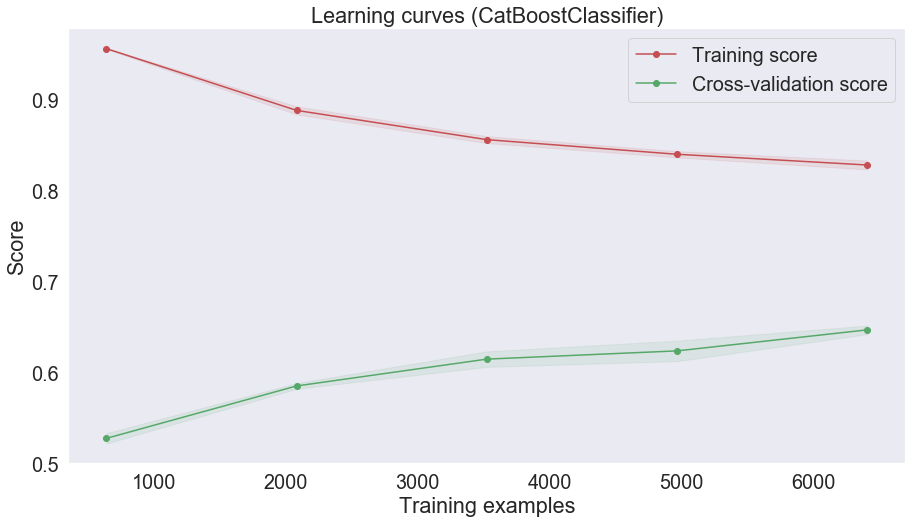

In [63]:
show_learning_curve_plot(model_catb, X_credit, Y_credit)

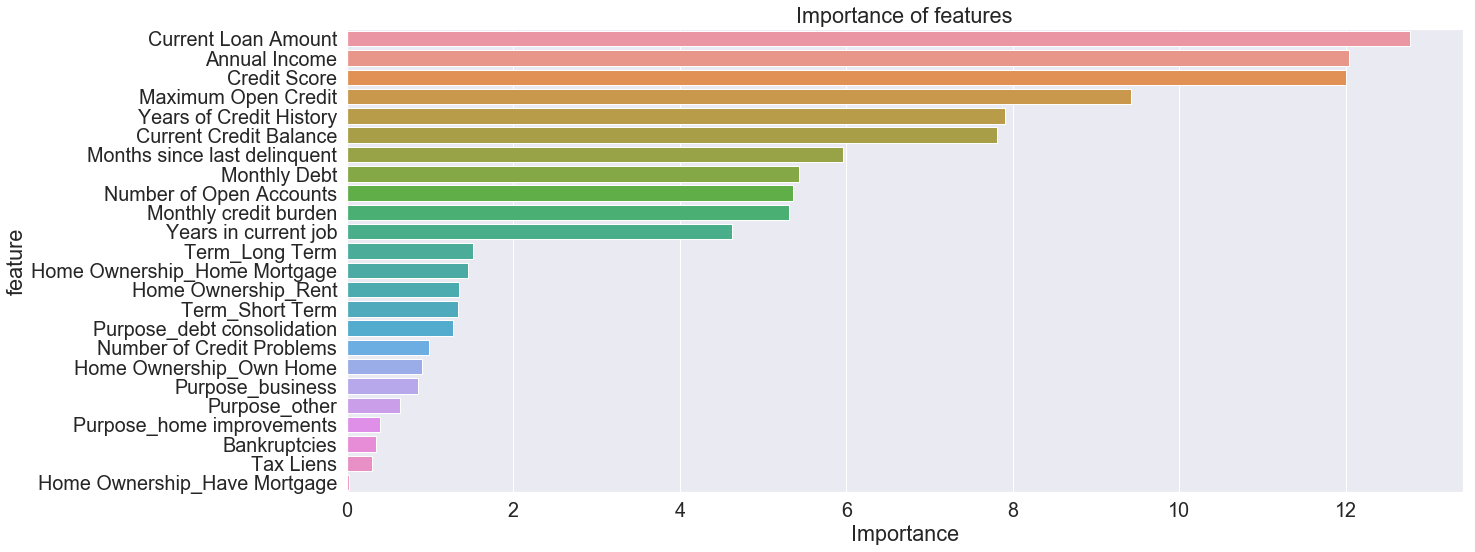

In [64]:
important_features_top = show_feature_importances(X_credit_train_scaled.columns, model_catb.feature_importances_, get_top=11)

In [65]:
Y_test_pred_probs = model_catb.predict_proba(X_credit_test_scaled)

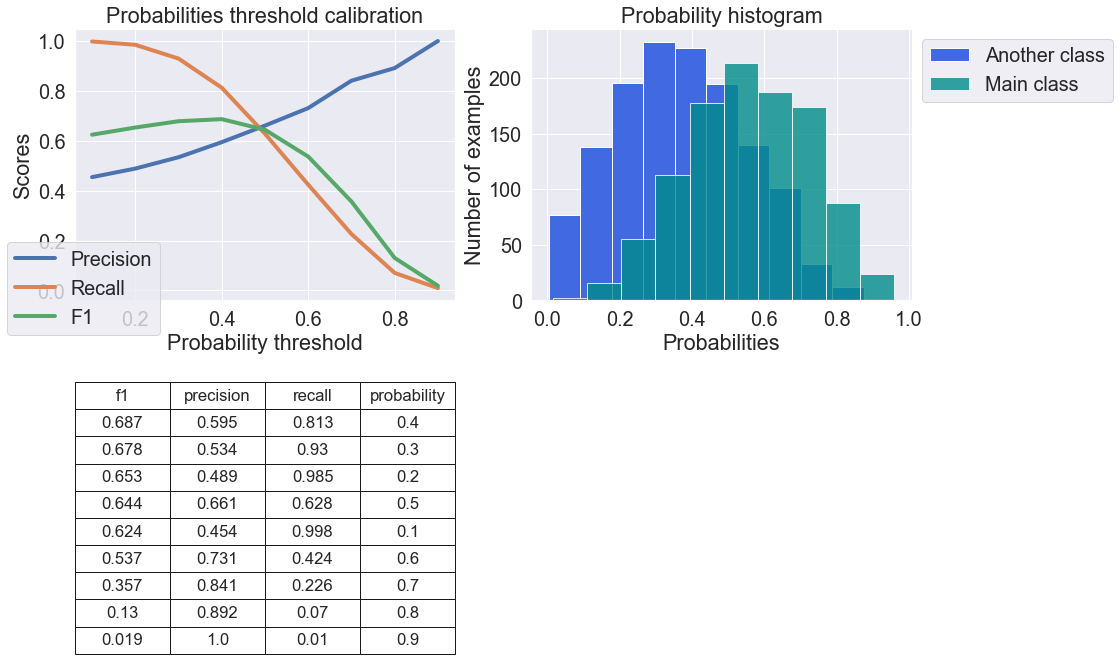

In [66]:
show_proba_calibration_plots(Y_test_pred_probs[:, 1], Y_credit_test)

In [67]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

In [68]:
params = {'n_estimators':[100, 200, 300], 
          'max_depth':[3, 5, 7, 11],
          'learning_rate':[0.01, 0.05, 0.1]}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_credit_train_scaled, Y_credit_train)

rs.best_score_, rs.best_params_

(0.6995049445279211,
 {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.05})

__Результаты лучшей модели.__

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True,
                                     n_estimators=300,
                                     max_depth=11,
                                     learning_rate=0.1,
                                     random_state=21)

model_catb.fit(X_credit_train_scaled[important_features_top], Y_credit_train)

Y_train_pred = model_catb.predict(X_credit_train_scaled)
Y_test_pred = model_catb.predict(X_credit_test_scaled)

get_classification_report(Y_credit_train, Y_train_pred, Y_credit_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4035
           1       1.00      1.00      1.00      3174

   micro avg       1.00      1.00      1.00      7209
   macro avg       1.00      1.00      1.00      7209
weighted avg       1.00      1.00      1.00      7209

TEST

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1352
           1       0.78      0.84      0.81      1052

   micro avg       0.83      0.83      0.83      2404
   macro avg       0.82      0.83      0.82      2404
weighted avg       0.83      0.83      0.83      2404

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1105  247
1                173  879


__Финальная модель.__

In [ ]:
scaler_credit_final = MinMaxScaler()
X_credit_scaled = pd.DataFrame(scaler_credit_final.fit_transform(X_credit), columns=X_credit.columns)

model_credit_final = catb.CatBoostClassifier(silent=True,
                                             n_estimators=300,
                                             max_depth=11,
                                             learning_rate=0.05,
                                             random_state=21)

model_credit_final.fit(X_credit_scaled, Y_credit);

In [ ]:
with open('scaler_credit.sc', 'wb') as file:
    pickle.dump(scaler_credit_final, file)

with open('model_credit.ml', 'wb') as file:
    pickle.dump(model_credit_final, file)

# __Прогнозирование на тестовом датасете.__

__Подготовка датасета.__

In [ ]:
Test_x_score_empty = df_test_clean[df_test_clean['Credit Score']
                                   .isnull()].drop(['Credit Score', 'Annual Income'], axis=1).copy()

Test_x_score_empty_scaled = pd.DataFrame(scaler_final_score.transform(Test_x_score_empty), 
                                          columns=Test_x_score_empty.columns)

Test_y_pred_score_final = rfr_score_final.predict(Test_x_score_empty_scaled)

df_test_clean_score = df_test_clean.copy()

df_test_clean_score.loc[df_test_clean_score['Credit Score'].isnull(), 'Credit Score'] = np.round(Test_y_pred_score_final)

In [ ]:
Test_x_income_empty = df_test_clean_score[df_test_clean_score['Annual Income']
                                   .isnull()].drop('Annual Income', axis=1).copy()

Test_x_income_empty_scaled = pd.DataFrame(scaler_final_income.transform(Test_x_income_empty), 
                                          columns=Test_x_income_empty.columns)

Test_y_pred_income_boxcox_final = rfr_income_final.predict(Test_x_income_empty_scaled)

df_test_full = df_test_clean.copy()

df_test_full.loc[df_test_full['Annual Income'].isnull(), 'Annual Income'] = Test_y_pred_income_boxcox_final
df_test_full.loc[df_test_full['Annual Income'].notnull(), 'Annual Income'] = \
    boxcox(df_test_full.loc[df_test_full['Annual Income'].notnull(), 'Annual Income'], lmbda=lmbda_income)

df_test_full['Monthly credit burden'] = df_test_full['Monthly Debt'] * 12 / df_test_full['Annual Income']

__Прогнозирование.__

In [ ]:
Test_x_credit_scaled = pd.DataFrame(scaler_credit_final.transform(df_test_full), columns=df_test_full.columns)

Test_y_credit = model_credit_final.predict(Test_x_credit_scaled)

Test_y_credit_proba = model_credit_final.predict_proba(Test_x_credit_scaled)

__Калибровка результатов__

In [ ]:
Test_y_credit_final = Test_y_credit.copy()
Test_y_credit_final[np.where(Test_y_credit_proba[:,1] > 0.45)] = 1

In [ ]:
print(f'До калибровки: {Counter(Test_y_credit)}')
print(f'После калибровки: {Counter(Test_y_credit_final)}')

__Сохранение результатов.__

In [ ]:
pred_credit = pd.DataFrame({'Credit Default':Test_y_credit_final}, columns=['Credit Default'])
pred_credit.to_csv('ABelinsky_predictions.csv', sep=',', index=None, encoding='utf-8')